# **Grouping based on Geo Data**
37명 4개씩 상점 분할하기
- **Total** : 151 개
- 1 개의 상호가 2개의 점포를 소유중 **(1개로 포함하여 작업)**

## **1 Loading & Prefixing**
간단한 내용 수정하기

In [1]:
import pandas as pd
table = pd.read_csv("./data/ourtown_store_geo2.csv")
# 애매한 업종내용 추가하기
table.loc[150,"업종"] = "컴퓨터수리"
table.loc[147,"업종"] = "오픈주방"
table.loc[145,"업종"] = "유리샷시"
table.loc[75,"업종"]  = "핸드폰매장"
# table[table["업종"]=="공연장"]
table[table["점주명"]=="조혁수"]
table[table["연번"]==44]

,연번,상호명,점주명,연락처,주소,address,addressroad,lon,lat,업종,행정동,사진,임대차,비고,기타
43,44,아이비스터디카페,조혁수,010-2536-9158,"신림로23길 34, 2층",서울특별시 관악구 신림로23길 34,서울특별시 관악구 신림동 1533-3,126.934652,37.469540,스터디카페,대학동,O,O,개별점포,NaN
44,44,아이비스터디카페,조혁수,010-2536-9158,"호암로24길 1, 2ㆍ3층",서울특별시 관악구 호암로24길 1,서울특별시 관악구 신림동 1525-11,126.933463,37.470192,스터디카페,대학동,O,O,개별점포,NaN


In [4]:
# Description
jobs    = ", ".join(sorted(set(table['업종'].to_list())))
compare = ", ".join(sorted(set(table['비고'].to_list())))
etc     = ", ".join(sorted(set(table['기타'].fillna('').to_list())))
counts  = len(jobs.split(','))
# print(f"업종 : {jobs}\n\n비고 : {compare}\n\n기타 : {etc}")
print(f"Counts : {counts}\n{jobs}")
table.tail(3)

Counts : 29
공연장, 기타판매, 떡집, 문구점, 미용업, 반찬판매, 부동산, 빨래방, 사진관, 서비스(녹음실), 서점, 슈퍼, 스터디카페, 실내스포츠업, 안경점, 약국, 오픈주방, 유리샷시, 음식점, 의류판매, 인쇄업, 정육점, 제과점, 주점, 카페, 컴퓨터수리, 피부미용, 학원, 핸드폰매장


,연번,상호명,점주명,연락처,주소,address,addressroad,lon,lat,업종,행정동,사진,임대차,비고,기타
148,148,삼거리식당,박영숙,010-2670-8392,신림로65길 31,서울특별시 관악구 신림로65길 31,서울특별시 관악구 신림동 1433-71,126.927769,37.484877,음식점,신림동,X,O,개별점포,신청자격 확인서 서류 미비(미동의 사항 다수)
149,149,스마일공인중개사사무소,장귀길,010-8249-0100,남부순환로214길 29,서울특별시 관악구 남부순환로214길 29,서울특별시 관악구 봉천동 881-17,126.947638,37.480334,부동산,청룡동,X,O,개별점포,NaN
150,150,컴플러스 컴퓨터,윤영중,010-8850-4114,난곡로24길 32,서울특별시 관악구 난곡로24길 32,서울특별시 관악구 신림동 655-36,126.921095,37.468968,컴퓨터수리,난곡동,O,O,난곡생활상권,NaN


## **2 Pre Processing & Filtering : Categorizing**
**데이터 분류기준 추가하기**

In [107]:
# Grouping
itemsales = [_.strip()  for _ in "기타판매,  문구점, 슈퍼, 인쇄업, 컴퓨터수리, 핸드폰매장, 안경점, 약국, 유리샷시,피부미용, 미용업, 의류판매".split(",")]
bizspace = [_.strip()  for _ in "부동산, 사진관, 서비스(녹음실), 공연장, 스터디카페, 실내스포츠업, 빨래방, 오픈주방, 학원,서점".split(",")]
food = [_.strip()  for _ in "떡집, 반찬판매, 정육점, 제과점, 주점, 카페, 음식점".split(",")]

_category = []  # Adding the Category values
for _ in table["업종"].to_list():
    if _ in itemsales:  _category.append('itemsales')
    elif _ in bizspace: _category.append('bizspace')
    elif _ in food:     _category.append('food')
    else: print(_ , " : no calssifcation")
table.insert(10, "category", _category)

# Filtering the DataFrame
from collections import Counter
table_filter = table.loc[:,["상호명","lon","lat","업종", "category"]]
table_filter.columns = ["name", "lon", 'lat', 'type', "category"]
print(dict(Counter(table_filter['category'])))
table_filter.head(2)

{'itemsales': 50, 'food': 79, 'bizspace': 22}


,name,lon,lat,type,category
0,모든홍삼,126.938397,37.485887,기타판매,itemsales
1,종로떡집,126.939588,37.487197,떡집,food


## **3 Pre Processing3 : Adding the Marker**
**Folium Map 에 활용할 데이터 Set 만들기**
```python
markers = { 
    "icon" : [
        "gift", "home", "cloud", "bell", "camera", "comment",
        "check", "heart", "user", "trash", "tags", "edit", "book", "bell"
        "lock", 'leaf', 'heart', 'globe', 'flag', 'film', 'file'
    ],
    "color" : [
        'red', 'purple', 'lightred', 'gray', 'black', 
        'lightgray', 'green', 'pink', 'white', 'darkblue', 
        'blue', 'darkgreen', 'lightblue', 'darkpurple', 
        'darkred', 'beige', 'lightgreen', 'orange', 'cadetblue'
    ],
}
```

In [108]:
marker = {
    "itemsales" :  ["darkred", "gift"],
    "bizspace" : ["cadetblue", "user"],
    "food" : ["cadetblue", "bell"],    
}
_marker = []
for _ in table_filter['category'].to_list():
    for _category in marker.keys():
        if _ == _category:
            _marker.append(marker[_category])
# DataFrame table
df_marker = pd.DataFrame(_marker)
df_marker.columns = ["color", 'icon']
example = table_filter.join(df_marker)
example.head(2)

,name,lon,lat,type,category,color,icon
0,모든홍삼,126.938397,37.485887,기타판매,itemsales,darkred,gift
1,종로떡집,126.939588,37.487197,떡집,food,cadetblue,bell


<br />

# **Folium Map**
**[Folium Tutorial](https://python-visualization.github.io/folium/quickstart.html#Markers)**

## **1 Visualization**

In [5]:
import folium
lat, long = example['lat'].mean(), example['lon'].mean() # 지도의 중심
instance_map = folium.Map([lat,long],zoom_start=14)
# Marking on the Map
for _ in range(len(example)):
    sub_lat, sub_long = example.loc[_,'lat'], example.loc[_,'lon']
    icon_name, color_name, title = example.loc[_,'icon'], example.loc[_,'color'], example.loc[_,'name']
    folium.Marker([ sub_lat, sub_long ], 
                      tooltip = title,\
                      popup = f"<p>{title}</p>",
                      icon = folium.Icon(icon=icon_name, color=color_name)).add_to(instance_map)
# instance_map.add_child(folium.LatLngPopup())
# instance_map.save('./Web/foliumap.html')
# instance_map

## **2 Marking the Label**
레이블 내용을 추가로 작업하는 option

In [6]:
# from folium import plugins
# icon = plugins.BeautifyIcon(
#     icon='plane',
#     border_color='darkblue',
#     icon_shape='circle'
# )
# icon_number = plugins.BeautifyIcon(
#     number = 10,
#     border_color='cadetblue',
#     text_color='cadetblue', 
#     icon_shape="circle",
#     inner_icon_style='margin=top:0;'
# )
# instance_map = instance_map.add_child(folium.Marker(
#     [37.4695, 126.9193],
#     popup = "<p>Testing</p>",
#     icon=icon_number
# ))
# # instance_map

<br />

# **Classification**
분류 작업을 진행 합니다

## **1 K means Classification**

In [7]:
# Compute k-means clustering.
from collections import Counter
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 37, init ='k-means++')
kmeans.fit(example[example.columns[1:3]]) 
# Adding the Label on the Table
example['label'] = kmeans.fit_predict(example[example.columns[1:3]])
example['label'] = list(map(lambda x : x+1 , example['label'])) # 0 을 지우고 1개씩 더하기
# Analysis DataSet
result_count = Counter(example['label'].to_list())
result_count = sorted([f"Id{k:02d}:{v:02d}"  for k,v in result_count.items()])
# example.to_csv("./data/ourtown_store_geo3.csv", index=None)
print(", ".join(result_count))
example.head(2)

Id01:02, Id02:03, Id03:07, Id04:08, Id05:02, Id06:09, Id07:07, Id08:04, Id09:09, Id10:01, Id11:06, Id12:03, Id13:01, Id14:02, Id15:02, Id16:06, Id17:13, Id18:02, Id19:02, Id20:01, Id21:06, Id22:04, Id23:04, Id24:03, Id25:01, Id26:03, Id27:07, Id28:01, Id29:01, Id30:02, Id31:02, Id32:02, Id33:06, Id34:01, Id35:13, Id36:03, Id37:02


,name,lon,lat,type,category,color,icon,label
0,모든홍삼,126.938397,37.485887,기타판매,itemsales,darkred,gift,7
1,종로떡집,126.939588,37.487197,떡집,food,cadetblue,bell,26


## **2 Marking the Number**
**[ICON_SHAPE_TYPES](https://python-visualization.github.io/folium/plugins.html?highlight=icon_shape#folium.plugins.BeautifyIcon.ICON_SHAPE_TYPES)** = `['circle', 'circle-dot', 'doughnut', 'rectangle-dot', 'marker', None]`

```
['red', 'purple', 'lightred', 'gray', 'black', 
'lightgray', 'green', 'pink', 'white', 'darkblue', 
'blue', 'darkgreen', 'lightblue', 'darkpurple', 
'darkred', 'beige', 'lightgreen', 'orange', 'cadetblue']
```

In [8]:
import folium
from folium import plugins
color_map = {'food':"red", 'itemsales':"blue", 'bizspace':'orange'}
lat, long = example['lat'].mean(), example['lon'].mean() # 지도의 중심
_map = folium.Map([lat,long],zoom_start=14)
# Marking on the Map
for _ in range(len(example)):
    sub_lat,   sub_long   = example.loc[_,'lat'],  example.loc[_,'lon']
    icon_name, color_name = example.loc[_,'icon'], example.loc[_,'color']
    title, number =  str(_) + " " + example.loc[_,'name'], example.loc[_, 'label']
    category      = example.loc[_, 'category']
    
    icon_number   = plugins.BeautifyIcon(
        number=str(number), icon_shape="marker", inner_icon_style='margin=top:0;',
            border_color=color_map[category] , text_color=color_map[category], border_width=2
    )
    
    folium.Marker([sub_lat, sub_long], tooltip=title, icon=icon_number).add_to(_map)
_map.save('./Web/foliumap.html')
_map

<br />

# **User Labeling**
사용자 분류 작업을 진행 합니다

## **1 Loading the DataSet**
데이터 자료 불러오기

In [1]:
import pandas as pd
file_name = "./data/ourtown_store_geo3.csv"
example = pd.read_csv(file_name).loc[:,['name','lon','lat','type','category','label']]
color_map = {'food':"red", 'itemsales':"blue", 'bizspace':'orange'}
example.head(2)

,name,lon,lat,type,category,label
0,모든홍삼,126.938397,37.485887,기타판매,itemsales,7
1,종로떡집,126.939588,37.487197,떡집,food,26


In [1]:
import folium
from folium import plugins
lat, long = example['lat'].mean(), example['lon'].mean() # 지도의 중심
_map = folium.Map([lat, long], zoom_start=14)
for _ in range(len(example)):  # Marking on the Map
    title =  str(_) + " " + example.loc[_,'name'],
    icon_number = plugins.BeautifyIcon(
        number = str(example.loc[_, 'label']),
        icon_shape = "marker",
        text_color = color_map[example.loc[_, 'category']], 
        border_color = color_map[example.loc[_, 'category']],
        border_width = 2, inner_icon_style = 'margin=top:0;',
    )
    folium.Marker([example.loc[_,'lat'], example.loc[_,'lon']], 
        tooltip = title,
        icon = icon_number).add_to(_map)
_map.save('./Web/foliumap.html')
# _map

NameError: name 'example' is not defined

## **2 Fixing the Marker Number**
Marker Number 추가하기

In [3]:
example[example["name"]=="행식이네 고깃집"]

,name,lon,lat,type,category,label
104,행식이네 고깃집,126.921264,37.469053,음식점,food,35


In [4]:
example['c_label'] = example['label']
label_index = [
    [70,49,81,84,86], [83,95,85,82], # 난향동 9개 분할
    [147,36,103,51,100], [99,88,94,89], [150,93,96,87], [91,97,105,98], [90,92,102,104], # 난곡동 18개 분할
    [],
    [39, 79, 31, 43, 44], # 44번 스터디 카페 2개 포함
    [80, 118, 65, 66],  # 동쪽 끝 지역
    [13, 40, 146, 33], [38, 35, 27, 106], [71, 145, 120, 52], [8, 12, 37, 119],
    [111, 48, 11, 64], [77, 42, 60, 15], [54, 34, 61, 20], [5, 6, 7, 75], 
    [29, 25, 78, 113], [28, 41, 47, 58], [4, 23, 21, 26], [1, 2, 24, 0],
    [9, 109, 149, 68], [3, 22, 74, 108], [18, 107, 55, 63],
    [72, 133, 53, 144], [69, 121, 141, 127], [124, 129, 130, 136], # 녹두거리 분할하기
    [125, 122, 128, 143], [139, 138, 134, 142], [123, 132, 126, 137],
    [115, 14, 59, 57], [112, 114, 50, 56], [32, 30, 117, 148] # 신림동 뒷골목 분할
]

# building the Marking Number
for no, _list in enumerate(label_index):
    for _ in _list:
        example.loc[_,'c_label'] = f"c{no}"

## **3 Visualization Mapping**
Marker Number 추가하기

In [5]:
count_rest, count_marked = 0, 0
_map = folium.Map([example['lat'].mean(), example['lon'].mean()], zoom_start=14)
for _ in range(len(example)):  # Marking on the Map
    title =  str(_) + " " + example.loc[_,'name'],
    number = str(example.loc[_, 'c_label'])
    color  = color_map[example.loc[_, 'category']]
    # Marking Data
    if number.find("c") != -1:
        color = 'gray'; count_marked += 1
    else: count_rest += 1
    icon_number = plugins.BeautifyIcon(
        number = number,
        icon_shape = "marker", text_color = color, border_color = color,
        border_width = 2, inner_icon_style = 'margin=top:0;',
    )
    folium.Marker([example.loc[_,'lat'], example.loc[_,'lon']], 
        tooltip = title,
        icon = icon_number).add_to(_map)
_map.save('./Web/foliumap.html')
# _map
(count_marked), count_rest

(135, 16)

## **4 Checking the Rest Data**
잔여 데이터 구분 찾기

In [6]:
index_rest = [no for no, _ in enumerate(example['c_label'].to_list()) if str(_).find("c") == -1]
folium_map(example.iloc[index_rest, :])

NameError: name 'folium_map' is not defined

In [12]:
58 / 4

14.5

In [13]:
count_dict = {}
for _ in example['c_label'].to_list():
    if _.find("c") != -1:
        if _ not in count_dict.keys():
            count_dict[_] = 1
        else:
            count_dict[_] += 1
count_dict

{'c14': 4,
 'c21': 4,
 'c13': 4,
 'c10': 4,
 'c05': 4,
 'c15': 4,
 'c06': 4,
 'c02': 4,
 'c07': 4,
 'c08': 4,
 'c11': 4,
 'c03': 4,
 'c12': 4,
 'c16': 5,
 'c17': 5,
 'c09': 9,
 'c04': 4,
 'c01': 4,
 'c19': 4,
 'c18': 5,
 'c20': 4}

In [25]:
_df = example[example["c_label"]=='c09']# .reset_index(drop=True)
_df.sort_values(['lon', 'lat'])
[70,49,81,84,86]
[83,95,85,82]

,name,lon,lat,type,category,label,c_label
70,카페비온,126.917727,37.462847,카페,food,9,c09
49,마음이 움직이는 토탈공예,126.918079,37.462919,기타판매,itemsales,9,c09
81,김현애보습학원,126.918079,37.462919,학원,bizspace,9,c09
84,영진부동산,126.918079,37.462919,부동산,bizspace,9,c09
86,영진떡방앗간,126.918079,37.462919,떡집,food,9,c09
83,모꼬지,126.918193,37.463017,카페,food,9,c09
95,난향면옥,126.918193,37.463017,음식점,food,9,c09
85,기똥찬 수제버거&컵밥,126.918386,37.462996,음식점,food,9,c09
82,옥이네,126.918543,37.463335,음식점,food,9,c09


In [17]:
list(example[example["c_label"]=='c09'].index)

[49, 70, 81, 82, 83, 84, 85, 86, 95]

In [15]:
# 70, 86, 85, 95, 82
def folium_map(df_map):
    df_map = df_map.reset_index(drop=True)
    _map = folium.Map([df_map['lat'].mean(), df_map['lon'].mean()], zoom_start=14)
    for _ in range(len(df_map)):
        folium.Marker(
            [df_map.loc[_,'lat'], df_map.loc[_,'lon']], 
            tooltip = df_map.loc[_,'name']
        ).add_to(_map)
    return _map

In [102]:
folium_map(example[example['c_label']=="c09"])

In [ ]:
49, 81, 82, 83, 84

In [ ]:
import folium
lat, long = example['lat'].mean(), example['lon'].mean() # 지도의 중심
# Marking on the Map
folium.Marker([ 37.462847,126.917727			]).add_to(temp_map)
instance_map
# instance_map.add_child(folium.LatLngPopup())
# instance_map.save('./Web/foliumap.html')
# instance_map

In [29]:
from folium import plugins
icon = plugins.BeautifyIcon(
    icon='plane',
    border_color='darkblue',
    icon_shape='circle'
)
icon_number = plugins.BeautifyIcon(
    number = 10,
    border_color='cadetblue',
    text_color='cadetblue', 
    icon_shape="circle",
    inner_icon_style='margin=top:0;'
)
instance_map = instance_map.add_child(folium.Marker(
    [37.4695, 126.9193],
    popup = "<p>Testing</p>",
    icon=icon_number
))
# instance_map

In [34]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
import matplotlib
import string
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
example.plot.scatter(x='lat', y='lon', ax=ax)
for _ in example.index:
    ax.annotate(example.loc[_]['label'], (example.loc[_]['lon'], example.loc[_]['lat']), color='red') 

ValueError: Image size of 496013x286538 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 360x360 with 1 Axes>

## **2 Marker Counter Number**

In [18]:
color = ['red', 'purple', 'lightred', 'gray', 'black', 
        'lightgray', 'green', 'pink', 'white', 'darkblue', 
        'blue', 'darkgreen', 'lightblue', 'darkpurple', 
        'darkred', 'beige', 'lightgreen', 'orange', 'cadetblue']

In [19]:
len(color)

19

In [18]:
# instance_map.save("test.svg")

In [19]:
# import io
# from PIL import Image

# img_data = instance_map._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('image.png')

In [21]:
# instance_map._to_png("test.png")

<br/>

# **Arterior 작가 작업구역 선정**
- **원칙 :** 거리가 가까운 업종끼리 묶는다 (종류는 무관)
- **예외1 :** 거리가 있으면 유사한 업종끼리 묶어서 난이도를 낮춘다
- **K Means 알고리즘** 은 **비지도학습** 으로, label 없이 자동으로 분류 기준을 세워서 동작 된다
- **KNN 알고리즘** 은 **지도학습** 으로, Labeling 되지 않은 데이터를 분류하는 알고리즘
- 작업 Process
    1. **K Means** 알고리즘을 활용하여 37개의 분류 데이터 생성
    1. 생성된 데이터를 기준으로 4개, 5개씩 임의로 분류
    1. 애매한 부분을 **KNN** 을 활용하여 Label 최종적 마무리 진행

## **1 Import Data to Visualization**
- [Matplotlib Font Setting](http://corazzon.github.io/matplotlib_font_setting)
- [Naver Map API Examples](https://navermaps.github.io/maps.js.ncp/docs/tutorial-3-drawing-restore.example.html)

/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0, flags=flags)


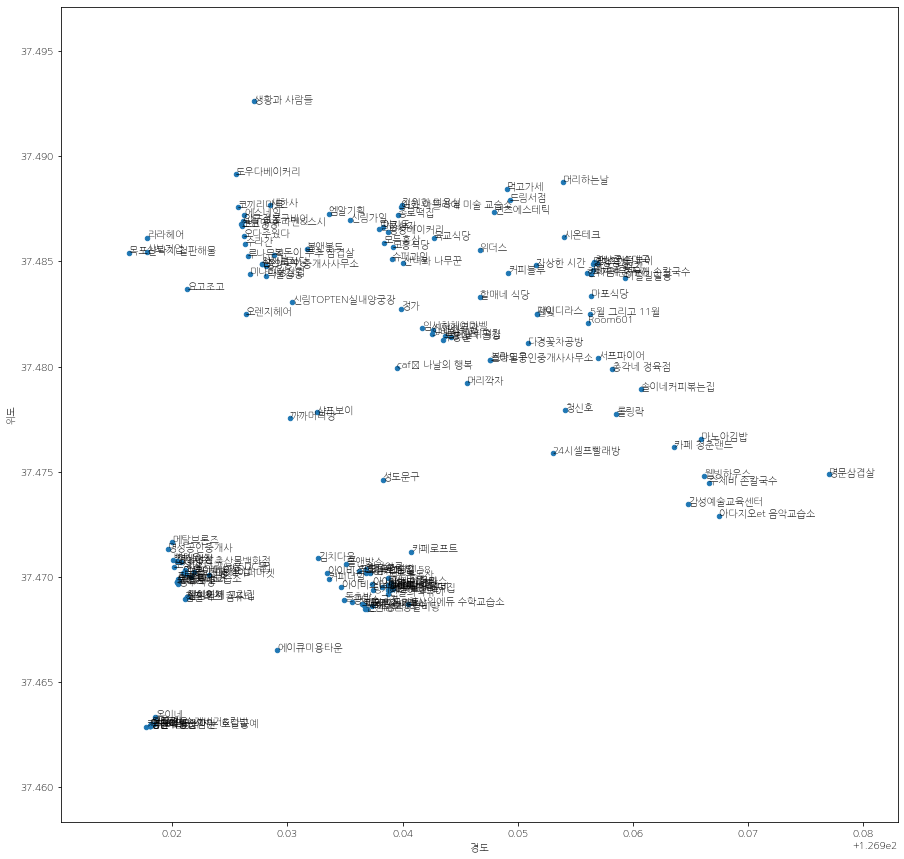

In [9]:
%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
import matplotlib
import string
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(15, 15))
example.plot.scatter(x='경도', y='위도', ax=ax)
for _ in example.index:
    ax.annotate(example.loc[_]['구분'], (example.loc[_]['경도'], example.loc[_]['위도']))    

# **K Means Classifier**
- **[Clustering GPS Coordinates and Forming Regions with Python](https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1)**
- **[Weighted K-Means Clustering of GPS Coordinates](https://medium.com/datadriveninvestor/weighted-k-means-clustering-of-gps-coordinates-python-7c6270846163)**

## **1 K Means Cluster 갯수 비교하기**
몇개를 기준으로 Clustering 할 것인가?

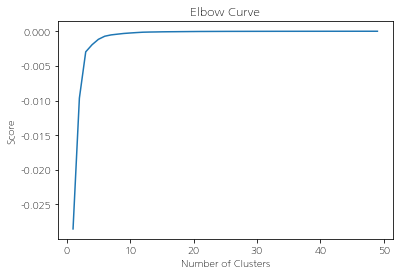

In [11]:
from sklearn.cluster import KMeans
# Clustering 기준을 몇개로 할 것인지 점수를 확인
# 분석결과 : 완만한 상승곡선으로 크게 구분시 차이가 없다
K_clusters = range(1,50)
kmeans = [ KMeans(n_clusters=i)  for i in K_clusters ]
Y_axis = example[['경도']]
X_axis = example[['위도']]
score  = [ kmeans[i].fit(Y_axis).score(Y_axis)  for i in range(len(kmeans)) ]

# Visualize
plt.plot(K_clusters, score); plt.xlabel('Number of Clusters')
plt.ylabel('Score'); plt.title('Elbow Curve'); plt.show()

## **2 K Means 37 개를 기준으로 비지도 학습**
37개를 기준으로 데이터 구분하기

In [12]:
from collections import Counter
# Compute k-means clustering.
kmeans = KMeans(n_clusters = 37, init ='k-means++')
kmeans.fit(example[example.columns[0:2]]) 
example['label'] = kmeans.fit_predict(example[example.columns[0:2]])
example['label'] = list(map(lambda x : x+1 , example['label'])) # 0 을 지우고 1개씩 더하기
# centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
# labels  = kmeans.predict(example[example.columns[0:2]]) # Labels of each point
result_count = Counter(example['label'].to_list())
result_count = sorted([f"Id{k:02d}:{v:02d}"  for k,v in result_count.items()])
", ".join(result_count)

'Id01:08, Id02:02, Id03:05, Id04:07, Id05:02, Id06:02, Id07:03, Id08:07, Id09:04, Id10:09, Id11:13, Id12:02, Id13:01, Id14:02, Id15:02, Id16:08, Id17:03, Id18:02, Id19:03, Id20:06, Id21:01, Id22:05, Id23:05, Id24:01, Id25:01, Id26:03, Id27:07, Id28:02, Id29:01, Id30:03, Id31:01, Id32:06, Id33:04, Id34:13, Id35:04, Id36:01, Id37:02'

In [20]:
example.head(3)

,경도,위도,구분,label
0,126.938397,37.485887,모든홍삼,8
1,126.939588,37.487197,종로떡집,35
2,126.939915,37.487700,김원화 미용실,35


## **3 Visualization**
37개를 기준으로 데이터 구분하기

In [32]:
# Adding the Color names
import matplotlib.colors as mcolors
color_names = list(mcolors.cnames.keys())
example['color'] = [color_names[_]  for _ in example["label"]]
example.head(3)

,경도,위도,구분,label,color
0,126.938397,37.485887,모든홍삼,8,blanchedalmond
1,126.939588,37.487197,종로떡집,35,darkslateblue
2,126.939915,37.487700,김원화 미용실,35,darkslateblue


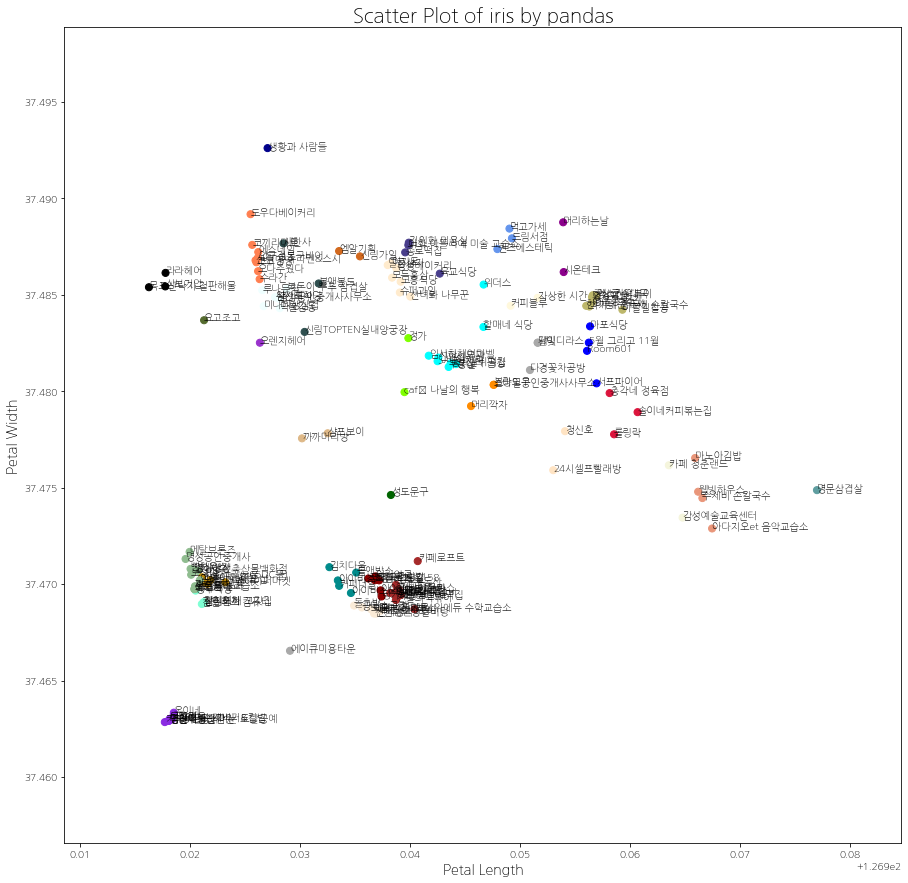

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
example.plot(kind = 'scatter',
              x = '경도', 
              y = '위도', 
              s = 50, # marker size
              c = example['color'],
              ax = ax) # marker color by group
for _ in example.index:
    ax.annotate(example.loc[_]['구분'], 
                (example.loc[_]['경도'], example.loc[_]['위도']), 
                fontsize=10) 
plt.title('Scatter Plot of iris by pandas', fontsize=20)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.show()

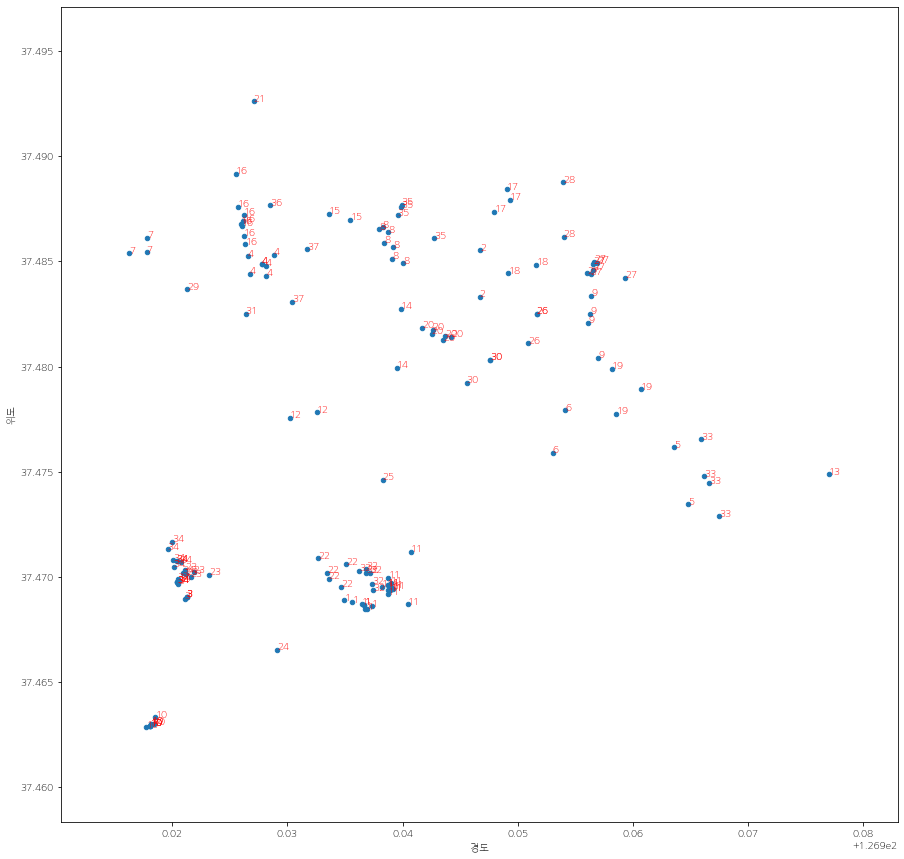

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
example.plot.scatter(x='경도', y='위도', ax=ax)
for _ in example.index:
    ax.annotate(example.loc[_]['label'], (example.loc[_]['경도'], example.loc[_]['위도']), color='red') 

148

In [ ]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

In [ ]:
example.head(2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kmeans_instance = KMeans(n_clusters=37, max_iter=1000, init='k-means++')

classifier = KNeighborsClassifier(n_neighbors = 4).fit(example[['경도','위도']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
example['clustering'] = labels
example.head(3)

In [ ]:
kmeans = KMeans(n_clusters = 3, max_iter=1000, init ='k-means++')
lat_long = X_weighted[X_weighted.columns[1:3]]
lot_size = X_weighted[X_weighted.columns[3]]
weighted_kmeans_clusters = kmeans.fit(lat_long, sample_weight = lot_size) # Compute k-means clustering.
X_weighted['cluster_label'] = kmeans.predict(lat_long, sample_weight = lot_size)
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = X_weighted['cluster_label'] # Labels of each point
X_weighted.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Weighted',fontsize=18, fontweight='bold')

# **KNeighbors Classifier**
- [Matplotlib Font Setting](http://corazzon.github.io/matplotlib_font_setting)
- [Sklearn Classification](https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b)

## **1 Import Data to Visualization**
- [Matplotlib Font Setting](http://corazzon.github.io/matplotlib_font_setting)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
X = np.array([
    [-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]
])
example = pd.DataFrame(X)
example.columns = ["x", "y"]
fig, ax = plt.subplots(figsize=(3, 3))
example.plot.scatter(x="x", y="y", ax= ax)
example.head(3)

## **2 K-Nearest Neighbors Scikit-Learn**
- [k-Nearest Neighbors](https://pythonbasics.org/k-nearest-neighbors)
- [Matplotlib Font Setting](http://corazzon.github.io/matplotlib_font_setting)

In [ ]:
K = 2
nbrs = NearestNeighbors(n_neighbors = K, algorithm = 'ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(distances)

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Dataset
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
target =  [0, 0, 0, 1, 1, 1]

# Fit a k-nearest neighbor model to the data
K = 3
model = KNeighborsClassifier(n_neighbors = K)
model.fit(X, target)
print(model)

# make predictions
print( '(-2,-2) is class'),
print( model.predict([[-2,-2]]) )

print( '(1,3) is class'),
print( model.predict([[1,3]]) )

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# dataset
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
target =  [0, 0, 0, 1, 1, 1]

# fit a k-nearest neighbor model to the data
K = 3
model = KNeighborsClassifier(n_neighbors = K)
model.fit(X, target)
print(model)

# make predictions
print( '(-2,-2) is class'),
print( model.predict([[-2,-2]]) )

print( '(1,3) is class'),
print( model.predict([[1,3]]) )

In [ ]:
# for neighbors.
locations_b = [
    ['BOOMVANG HELIPORT / OIL PLATFORM', 27.35, -94.633],
    ['LEE COUNTY AIRPORT', 36.654, -83.218],
    ['ELLINGTON', 35.507, -86.804],
    ['LAWRENCEVILLE BRUNSWICK MUNI', 36.773, -77.794],
    ['PUTNAM CO', 39.63, -86.814]
]# Converting the lists to DataFrames. We will build the tree with
# the first and execute the query on the second.
locations_a = pd.DataFrame(locations_a, columns = column_names)
locations_b = pd.DataFrame(locations_b, columns = column_names)

In [ ]:
kd = KDTree(locations_a[["LAT", "LON"]].values, metric='euclidean')

In [ ]:
# The amount of neighbors to return.
# Executes a query with the second group. This will return two
# arrays.
from sklearn.neighbors import BallTree, KDTree
k = 2
distances, indices = kd.query(locations_b[["LAT", "LON"]], k = k)

In [ ]:
indices

In [ ]:
dataset = [
    [2.7810836,2.550537003,0],
    [1.465489372,2.362125076,0],
    [3.396561688,4.400293529,0],
    [1.38807019,1.850220317,0],
    [3.06407232,3.005305973,0],
    [7.627531214,2.759262235,1],
    [5.332441248,2.088626775,1],
    [6.922596716,1.77106367,1],
    [8.675418651,-0.242068655,1],
    [7.673756466,3.508563011,1]
]

In [ ]:
# 유클리드 거리 구하는 공식
# calculate the Euclidean distance between two vectors
# row = [x, y, type]
from math import sqrt
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

In [ ]:
row0 = [3,3]
for row in dataset:
    distance = euclidean_distance(row0, row)
    print(distance)

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer_data = load_breast_cancer()

In [ ]:
import pandas as pd
df_data = pd.DataFrame(breast_cancer_data.data)
df_data.head(3)

In [ ]:
df_labels = pd.DataFrame(breast_cancer_data.target)
df_labels.head()
print(breast_cancer_data.target_names)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3)

In [ ]:
training_points = [
  [0.5, 0.2, 0.1],
  [0.9, 0.7, 0.3],
  [0.4, 0.5, 0.7]
]
training_labels = [0, 1, 1]
classifier.fit(training_points, training_labels)

In [ ]:
unknown_points = [
  [0.2, 0.1, 0.7],
  [0.4, 0.7, 0.6],
  [0.5, 0.8, 0.1]
]
guesses = classifier.predict(unknown_points)
guesses

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
table.describe()

In [ ]:
example.head(2)

## **2 K Means Clustering**
- [Matplotlib Font Setting](http://corazzon.github.io/matplotlib_font_setting)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 4).fit(example[['경도','위도']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
example['clustering'] = labels
example.head(3)

In [ ]:
from collections import Counter


In [ ]:
Counter(example['clustering'].to_list())